# ENGLISH TO GERMAN TRANSLATION

# ENCODER-DECODER WITH ATTENTION MECHANISM

In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split
import string
from string import digits
import re
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Input, Dense,Embedding, Concatenate, TimeDistributed
from tensorflow.keras.models import Model,load_model, model_from_json
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
import pickle as pkl
import numpy as np

In [2]:
with open('deu.txt','r', encoding="utf8") as f:
  data = f.read()

In [3]:
uncleaned_data_list = data.strip().split('\n')
len(uncleaned_data_list)

249230

In [53]:
uncleaned_data_list = uncleaned_data_list[:20000]

In [54]:
english_word = []
german_word = []
cleaned_data_list = []
for word in uncleaned_data_list:
  english_word.append(word.split('\t')[:-1][0])
  german_word.append(word.split('\t')[:-1][1])

In [55]:
len(english_word), len(german_word)

(20000, 20000)

In [56]:
language_data = pd.DataFrame(columns=['English','German'])
language_data['English'] = english_word
language_data['German'] = german_word

In [57]:
language_data.to_csv('language_data.csv', index=False)

In [58]:
language_data = pd.read_csv('language_data.csv')
language_data.head()

,English,German
0,Go.,Geh.
1,Hi.,Hallo!
2,Hi.,Grüß Gott!
3,Run!,Lauf!
4,Run.,Lauf!


In [59]:
english_text = language_data['English'].values
german_text = language_data['German'].values

In [60]:
english_text[0], german_text[0]

('Go.', 'Geh.')

In [61]:
len(english_text), len(german_text)

(20000, 20000)

In [62]:
#to lower case
english_text_ = [x.lower() for x in english_text]
german_text_ = [x.lower() for x in german_text]
#removing inverted commas
english_text_ = [re.sub("'",'',x) for x in english_text_]
german_text_ = [re.sub("'",'',x) for x in german_text_]
def remove_punc(text_list):
  table = str.maketrans('', '', string.punctuation)
  removed_punc_text = []
  for sent in text_list:
    sentance = [w.translate(table) for w in sent.split(' ')]
    removed_punc_text.append(' '.join(sentance))
  return removed_punc_text
english_text_ = remove_punc(english_text_)
german_text_ = remove_punc(german_text_)
remove_digits = str.maketrans('', '', digits)
removed_digits_text = []
for sent in english_text_:
  sentance = [w.translate(remove_digits) for w in sent.split(' ')]
  removed_digits_text.append(' '.join(sentance))
english_text_ = removed_digits_text

# removing the stating and ending whitespaces
english_text_ = [x.strip() for x in english_text_]
german_text_ = [x.strip() for x in german_text_]

In [63]:
# Putting the start and end words in the german  sentances
german_text_ = ["start " + x + " end" for x in german_text_]

In [64]:
# manipulated_german_text_
german_text_[0], english_text_[0]

('start geh end', 'go')

In [65]:
X = english_text_
Y = german_text_

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.1)
len(X_train),len(y_train), len(X_test), len(y_test)

(18000, 18000, 2000, 2000)

In [67]:
def Max_length(data):
  max_length_ = max([len(x.split(' ')) for x in data])
  return max_length_

#Training data
max_length_english = Max_length(X_train)
max_length_german = Max_length(y_train)

#Test data
max_length_english_test = Max_length(X_test)
max_length_german_test = Max_length(y_test)
max_length_german, max_length_english

(12, 5)

In [68]:
englishTokenizer = Tokenizer()
englishTokenizer.fit_on_texts(X_train)
Eword2index = englishTokenizer.word_index
vocab_size_source = len(Eword2index) + 1

X_train = englishTokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=max_length_english, padding='post')

X_test = englishTokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen = max_length_english, padding='post')

In [69]:
germanTokenizer = Tokenizer()
germanTokenizer.fit_on_texts(y_train)
pword2index = germanTokenizer.word_index
vocab_size_target = len(pword2index) + 1

y_train = germanTokenizer.texts_to_sequences(y_train)
y_train = pad_sequences(y_train, maxlen=max_length_german, padding='post')

y_test = germanTokenizer.texts_to_sequences(y_test)
y_test = pad_sequences(y_test, maxlen =max_length_german , padding='post')

In [70]:
vocab_size_source, vocab_size_target

(3400, 5413)

In [71]:
with open('NMT_data.pkl','wb') as f:
  pkl.dump([X_train, y_train, X_test, y_test],f)

with open('NMT_Etokenizer.pkl','wb') as f:
  pkl.dump([vocab_size_source, Eword2index, englishTokenizer], f)

with open('NMT_Mtokenizer.pkl', 'wb') as f:
  pkl.dump([vocab_size_target, pword2index, germanTokenizer], f)

In [72]:
X_train[0], y_train[0]

(array([   1,   57, 1621,    0,    0]),
 array([   1,    4,   13,   36, 2865,    2,    0,    0,    0,    0,    0,
           0]))

In [73]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [74]:
y_train[:, 1:].shape

(18000, 11)

In [75]:
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [76]:
from keras import backend as K 
K.clear_session() 
latent_dim = 500 

# Encoder 
encoder_inputs = Input(shape=(max_length_english,)) 
enc_emb = Embedding(vocab_size_source, latent_dim,trainable=True)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True, dropout=0.2) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True, dropout=0.2) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True, dropout=0.2) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(vocab_size_target, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.1) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(vocab_size_target, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 5, 500)       1700000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 5, 500), (No 2002000     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
_______________________________________________________________________________________

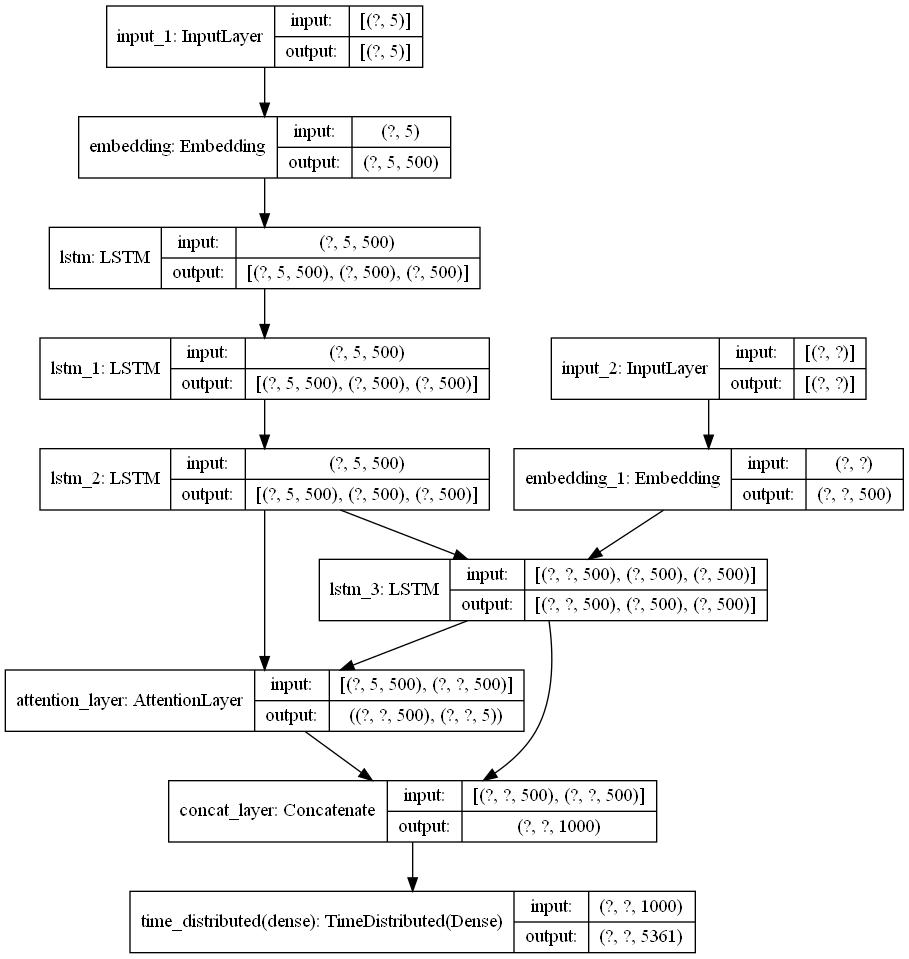

In [59]:
# plot_model(model, to_file='train_model.png', show_shapes=True)

In [77]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [78]:
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=2,
                                                   mode="max")

In [80]:
history = model.fit([X_train, y_train[:,:-1]], y_train.reshape(y_train.shape[0], y_train.shape[1],1)[:,1:], 
                    epochs=50, 
                    callbacks=[lr_schedule],
                    batch_size=512,
                    validation_data = ([X_test, y_test[:,:-1]], y_test.reshape(y_test.shape[0], y_test.shape[1], 1)[:,1:]))

Epoch 1/50
36/36 [==============================] - 198s 5s/step - loss: 3.5883 - accuracy: 0.6028 - val_loss: 2.1177 - val_accuracy: 0.6531
Epoch 2/50
36/36 [==============================] - 152s 4s/step - loss: 2.1171 - accuracy: 0.6660 - val_loss: 1.9541 - val_accuracy: 0.6901
Epoch 3/50
36/36 [==============================] - 145s 4s/step - loss: 1.9486 - accuracy: 0.7015 - val_loss: 1.7961 - val_accuracy: 0.7286
Epoch 4/50
36/36 [==============================] - 149s 4s/step - loss: 1.8114 - accuracy: 0.7240 - val_loss: 1.7054 - val_accuracy: 0.7362
Epoch 5/50
36/36 [==============================] - 148s 4s/step - loss: 1.7287 - accuracy: 0.7318 - val_loss: 1.6560 - val_accuracy: 0.7369
Epoch 6/50
36/36 [==============================] - 148s 4s/step - loss: 1.6682 - accuracy: 0.7363 - val_loss: 1.6128 - val_accuracy: 0.7404
Epoch 7/50
36/36 [==============================] - 140s 4s/step - loss: 1.6127 - accuracy: 0.7400 - val_loss: 1.5758 - val_accuracy: 0.7443
Epoch 8/50
36

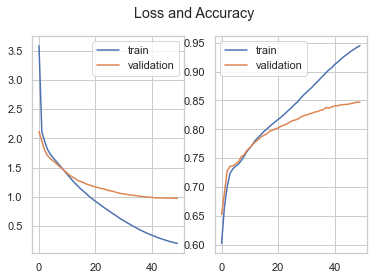

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid') 
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Loss and Accuracy')
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train','validation'])
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.legend(['train','validation'])

In [82]:
model_json = model.to_json()
with open("NMT_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("NMT_model_weight.h5")
print("Saved model to disk")

Saved model to disk


In [83]:
# loading the model architecture and asigning the weights
json_file = open('NMT_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_loaded = model_from_json(loaded_model_json, custom_objects={'AttentionLayer': AttentionLayer})
# load weights into new model
model_loaded.load_weights("NMT_model_weight.h5")

In [84]:
with open('NMT_Etokenizer.pkl','rb') as f:
  vocab_size_source, Eword2index, englishTokenizer = pkl.load(f)

with open('NMT_Mtokenizer.pkl', 'rb') as f:
  vocab_size_target, Mword2index, germanTokenizer = pkl.load(f)

with open('NMT_data.pkl','rb') as f:
  X_train, y_train, X_test, y_test = pkl.load(f)

In [85]:
Eindex2word = englishTokenizer.index_word
pindex2word = germanTokenizer.index_word

In [86]:
model_loaded.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 5, 500)       1700000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 5, 500), (No 2002000     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
_______________________________________________________________________________________

In [87]:
latent_dim=500
# encoder inference
encoder_inputs = model_loaded.input[0]  #loading encoder_inputs
encoder_outputs, state_h, state_c = model_loaded.layers[6].output #loading encoder_outputs

print(encoder_outputs.shape)

encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(32,latent_dim))

# Get the embeddings of the decoder sequence
decoder_inputs = model_loaded.layers[3].output

print(decoder_inputs.shape)
dec_emb_layer = model_loaded.layers[5]

dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_lstm = model_loaded.layers[7]
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_layer = model_loaded.layers[8]
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])

concate = model_loaded.layers[9]
decoder_inf_concat = concate([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_dense = model_loaded.layers[10]
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

(None, 5, 500)
(None, None)


In [88]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = pword2index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        if sampled_token_index == 0:
          break
        else:
          sampled_token = pindex2word[sampled_token_index]

          if(sampled_token!='end'):
              decoded_sentence += ' '+sampled_token

              # Exit condition: either hit max length or find stop word.
              if (sampled_token == 'end' or len(decoded_sentence.split()) >= (26-1)):
                  stop_condition = True

          # Update the target sequence (of length 1).
          target_seq = np.zeros((1,1))
          target_seq[0, 0] = sampled_token_index

          # Update internal states
          e_h, e_c = h, c

    return decoded_sentence

In [89]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=pword2index['start']) and i!=pword2index['end']):
        newString=newString+pindex2word[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+Eindex2word[i]+' '
    return newString

In [90]:
print(decode_sequence(X_test[0].reshape(1,5)))

 du wirst gut aus gehen


In [95]:
import nltk.translate.bleu_score as bleu
blue1=[]
# blue2=[]
# blue3=[]
# blue4=[]
for i in range(1000):
    if len(seq2summary(y_test[i]))!=0:
        translated = decode_sequence(X_test[i].reshape(1,5))
        print(i+1)
        print("english: ",seq2text(X_test[i]))
        print("german : ",seq2summary(y_test[i]))
        print("predicted: ",translated)
        print('Cumulative 1-gram BLEU score: {:.4f}'.format(bleu.sentence_bleu(seq2summary(y_test[i]), translated, weights=(1, 0, 0, 0))))
        # print('Cumulative 2-gram BLEU score: {:.4f}'.format(bleu.sentence_bleu(seq2summary(y_test[i]), translated, weights=(0.5, 0.5, 0, 0))))
        # print('Cumulative 3-gram BLEU score: {:.4f}'.format(bleu.sentence_bleu(seq2summary(y_test[i]), translated, weights=(0.33, 0.33, 0.33, 0))))
        # print('Cumulative 4-gram BLEU score: {:.4f}'.format(bleu.sentence_bleu(seq2summary(y_test[i]), translated, weights=(0.25, 0.25, 0.25, 0.25))))
        bluescore1=bleu.sentence_bleu(seq2summary(y_test[i]), translated, weights=(1, 0, 0, 0))
        blue1.append(bluescore1)

        # bluescore2=bleu.sentence_bleu(seq2summary(y_test[i]), translated, weights=(0.5, 0.5, 0, 0))
        # blue2.append(bluescore2)

        # bluescore3=bleu.sentence_bleu(seq2summary(y_test[i]), translated, weights=(0.33, 0.33, 0.33, 0))
        # blue3.append(bluescore3)

        # bluescore4=bleu.sentence_bleu(seq2summary(y_test[i]), translated, weights=(0.25, 0.25, 0.25, 0.25))
        # blue4.append(bluescore4)    
        print("____________________________________________________________________________") 

1
english:  youll be fine 
german :  du wirst schon klarkommen 
predicted:   du wirst gut aus gehen
Cumulative 1-gram BLEU score: 0.5217
____________________________________________________________________________


C:\Users\apratim sadhu\anaconda3\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\apratim sadhu\anaconda3\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\apratim sadhu\anaconda3\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use Smoo

2
english:  thats too easy 
german :  das ist zu leicht 
predicted:   das ist zu einfach
Cumulative 1-gram BLEU score: 0.5789
____________________________________________________________________________
3
english:  im off beer 
german :  ich trinke kein bier mehr 
predicted:   ich bin nicht glücklich
Cumulative 1-gram BLEU score: 0.3333
____________________________________________________________________________
4
english:  well stop you 
german :  wir werden dich aufhalten 
predicted:   wir werden dich stoppen
Cumulative 1-gram BLEU score: 0.4167
____________________________________________________________________________
5
english:  i smelled it 
german :  ich habe es gerochen 
predicted:   ich habe tom angerufen
Cumulative 1-gram BLEU score: 0.4783
____________________________________________________________________________
6
english:  tom is through 
german :  tom ist fertig 
predicted:   tom ist es gerade einkaufen
Cumulative 1-gram BLEU score: 0.3571
_____________________________

In [99]:
len(blue1)

997

In [102]:
blue1

[0.5217391304347826,
 0.5789473684210527,
 0.3333333333333333,
 0.4166666666666667,
 0.4782608695652174,
 0.3571428571428572,
 0.5384615384615384,
 0.42857142857142855,
 0.5454545454545454,
 0.4117647058823529,
 0.4,
 0.5,
 0.5833333333333334,
 0.4482758620689655,
 0.5,
 0.4666666666666667,
 0.4444444444444444,
 0.4,
 0.5238095238095238,
 0.42857142857142855,
 0.4782608695652174,
 0.4666666666666667,
 0.5,
 0.875,
 0.6153846153846154,
 0.43478260869565216,
 0.5294117647058824,
 0.45454545454545453,
 0.5789473684210527,
 0.5454545454545454,
 0.5263157894736842,
 0.5555555555555556,
 0.42857142857142855,
 0.5714285714285714,
 0.3103448275862069,
 0.4375,
 0.23333333333333334,
 0.3478260869565218,
 0.391304347826087,
 0.5625,
 0.5294117647058824,
 0.4090909090909091,
 0.5263157894736842,
 0.4,
 0.6666666666666666,
 0.5789473684210527,
 0.4074074074074074,
 0.2692307692307693,
 0.5,
 0.4090909090909091,
 0.4,
 0.5263157894736842,
 0.4666666666666667,
 0.375,
 0.4117647058823529,
 0.25,
 0.

In [103]:
print(sum(blue1)/len(blue1))

0.4696275504890712


In [109]:
!pip3 install jiwer


You should consider upgrading via the 'c:\users\apratim sadhu\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [112]:
import jiwer

In [115]:
from jiwer import wer
werlist=[]
for i in range(1000):
    if len(seq2summary(y_test[i]))!=0:
        translated = decode_sequence(X_test[i].reshape(1,5))
        print(i+1)
        print("english: ",seq2text(X_test[i]))
        print("german : ",seq2summary(y_test[i]))
        print("predicted: ",translated)
        werscore = jiwer.wer(seq2summary(y_test[i]), translated)
        print("wer:", werscore)
        werlist.append(werscore) 
        print("____________________________________________________________________________") 

1
english:  youll be fine 
german :  du wirst schon klarkommen 
predicted:   du wirst gut aus gehen
wer: 0.75
____________________________________________________________________________
2
english:  thats too easy 
german :  das ist zu leicht 
predicted:   das ist zu einfach
wer: 0.25
____________________________________________________________________________
3
english:  im off beer 
german :  ich trinke kein bier mehr 
predicted:   ich bin nicht glücklich
wer: 0.8
____________________________________________________________________________
4
english:  well stop you 
german :  wir werden dich aufhalten 
predicted:   wir werden dich stoppen
wer: 0.25
____________________________________________________________________________
5
english:  i smelled it 
german :  ich habe es gerochen 
predicted:   ich habe tom angerufen
wer: 0.5
____________________________________________________________________________
6
english:  tom is through 
german :  tom ist fertig 
predicted:   tom ist es gerade

In [116]:
werlist

[0.75,
 0.25,
 0.8,
 0.25,
 0.5,
 1.0,
 0.5,
 1.3333333333333333,
 0.5,
 0.6666666666666666,
 2.0,
 0.25,
 1.0,
 0.3333333333333333,
 0.6666666666666666,
 1.0,
 0.8,
 1.0,
 0.6,
 0.5,
 0.5,
 1.0,
 0.75,
 1.0,
 0.3333333333333333,
 0.25,
 0.6,
 0.25,
 0.4,
 0.3333333333333333,
 0.2,
 0.3333333333333333,
 0.6666666666666666,
 0.0,
 0.25,
 0.3333333333333333,
 1.5,
 1.0,
 0.75,
 0.6,
 0.8333333333333334,
 1.0,
 0.25,
 0.6666666666666666,
 0.0,
 0.0,
 1.25,
 1.5,
 0.3333333333333333,
 0.25,
 0.75,
 0.6666666666666666,
 0.3333333333333333,
 0.6666666666666666,
 1.0,
 1.0,
 0.5,
 0.5,
 0.0,
 1.0,
 0.5,
 0.75,
 2.5,
 0.6666666666666666,
 1.0,
 4.0,
 1.0,
 1.0,
 1.0,
 0.8,
 0.25,
 0.6666666666666666,
 1.0,
 0.5,
 1.0,
 0.3333333333333333,
 0.0,
 0.5,
 0.5,
 1.0,
 1.0,
 0.25,
 1.0,
 0.0,
 0.5,
 0.3333333333333333,
 0.5,
 0.25,
 0.6,
 1.0,
 0.0,
 0.25,
 0.3333333333333333,
 0.5,
 0.0,
 0.0,
 0.5,
 1.0,
 1.2,
 0.0,
 0.5,
 0.3333333333333333,
 0.4,
 1.5,
 0.3333333333333333,
 0.3333333333333333,
 

In [117]:
print(sum(werlist)/len(werlist))

0.6465205139227209
